In [2]:
import math
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from utils import *
from ipywidgets import interact

Orientation image
""

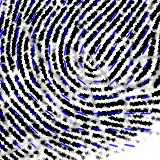

,
,

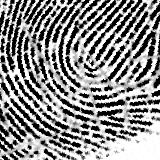
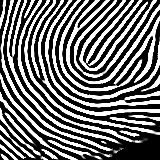

,,
,,

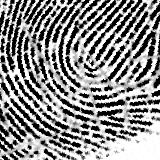
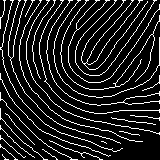
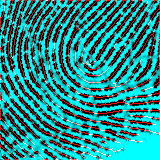

,,
,,

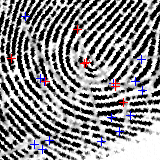
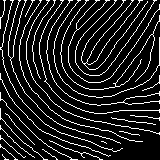
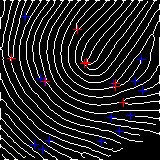

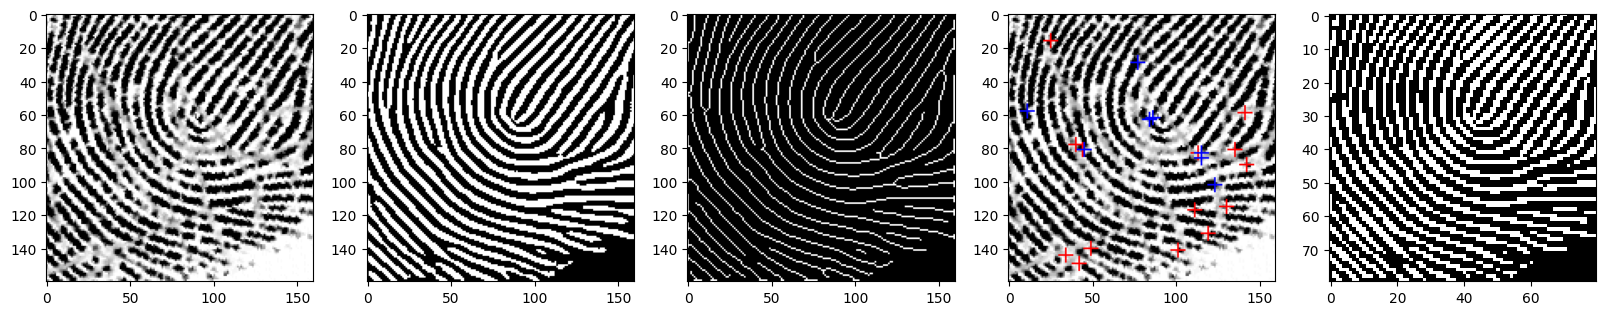

In [5]:
from scipy.interpolate import interp1d

def compute_crossing_number(values):
    return np.count_nonzero(values < np.roll(values, -1))


def smooth_skeleton(skeleton, num_points=10000):
    # 将骨架坐标转换为参数化的曲线形式
    skeleton_points = np.argwhere(skeleton == 255)
    x = skeleton_points[:, 1]
    y = skeleton_points[:, 0]
    t = np.arange(len(x))
    t_new = np.linspace(0, len(x)-1, num_points)

    # 使用线性插值进行平滑
    interp_func = interp1d(t, np.column_stack((x, y)), kind='linear', axis=0)
    smoothed_skeleton = interp_func(t_new)
    
    x_smooth_mapped = np.round(smoothed_skeleton[:, 0]).astype(int)
    y_smooth_mapped = np.round(smoothed_skeleton[:, 1]).astype(int)
    smoothed_image = np.zeros_like(skeleton)
    smoothed_image[y_smooth_mapped, x_smooth_mapped] = 255

    return smoothed_image


def process(show_fingerprint, fingerprint, visual=False):
    # Calculate the local gradient (using Sobel filters)
    gx, gy = cv.Sobel(fingerprint, cv.CV_32F, 1, 0), cv.Sobel(fingerprint, cv.CV_32F, 0, 1)

    # Calculate the magnitude of the gradient for each pixel
    gx2, gy2 = gx**2, gy**2
    gm = np.sqrt(gx2 + gy2)

    # Integral over a square window
    sum_gm = cv.boxFilter(gm, -1, (25, 25), normalize = False)

    # Use a simple threshold for segmenting the fingerprint pattern
    thr = sum_gm.max() * 0.2
    mask = cv.threshold(sum_gm, thr, 255, cv.THRESH_BINARY)[1].astype(np.uint8)

    W = (23, 23)
    gxx = cv.boxFilter(gx2, -1, W, normalize = False)
    gyy = cv.boxFilter(gy2, -1, W, normalize = False)
    gxy = cv.boxFilter(gx * gy, -1, W, normalize = False)
    gxx_gyy = gxx - gyy
    gxy2 = 2 * gxy

    orientations = (cv.phase(gxx_gyy, -gxy2) + np.pi) / 2 # '-' to adjust for y axis direction
    sum_gxx_gyy = gxx + gyy
    strengths = np.divide(cv.sqrt((gxx_gyy**2 + gxy2**2)), sum_gxx_gyy, out=np.zeros_like(gxx), where=sum_gxx_gyy!=0)
    if visual:
        show(draw_orientations(fingerprint, orientations, strengths, mask, 1, 16), 'Orientation image')

    region = fingerprint[10:90,80:130]
    # before computing the x-signature, the region is smoothed to reduce noise
    smoothed = cv.blur(region, (5,5), -1)
    xs = np.sum(smoothed, 1) # the x-signature of the region

    # Find the indices of the x-signature local maxima
    local_maxima = np.nonzero(np.r_[False, xs[1:] > xs[:-1]] & np.r_[xs[:-1] >= xs[1:], False])[0]

    # Calculate all the distances between consecutive peaks
    distances = local_maxima[1:] - local_maxima[:-1]

    # Estimate the ridge line period as the average of the above distances
    ridge_period = np.average(distances)
    if np.isnan(ridge_period):
        ridge_period = 15

    # Create the filter bank
    or_count = 8
    gabor_bank = [gabor_kernel(ridge_period, o) for o in np.arange(0, np.pi, np.pi/or_count)]

    # Filter the whole image with each filter
    # Note that the negative image is actually used, to have white ridges on a black background as a result
    nf = 255-fingerprint
    all_filtered = np.array([cv.filter2D(nf, cv.CV_32F, f) for f in gabor_bank])

    y_coords, x_coords = np.indices(fingerprint.shape)
    # For each pixel, find the index of the closest orientation in the gabor bank
    orientation_idx = np.round(((orientations % np.pi) / np.pi) * or_count).astype(np.int32) % or_count
    # Take the corresponding convolution result for each pixel, to assemble the final result
    filtered = all_filtered[orientation_idx, y_coords, x_coords]
    # Convert to gray scale and apply the mask
    enhanced = mask & np.clip(filtered, 0, 255).astype(np.uint8)
    if visual:
        show(show_fingerprint, enhanced)

    # Binarization
    _, ridge_lines = cv.threshold(enhanced, 64, 255, cv.THRESH_BINARY)

    # Thinning
    skeleton = cv.ximgproc.thinning(ridge_lines, thinningType = cv.ximgproc.THINNING_GUOHALL)
    if visual:
        show(show_fingerprint, skeleton, cv.merge((fingerprint, fingerprint, skeleton)))

    # Create a filter that converts any 8-neighborhood into the corresponding byte value [0,255]
    cn_filter = np.array([[  1,  2,  4],
                          [128,  0,  8],
                          [ 64, 32, 16]
                         ])

    # Create a lookup table that maps each byte value to the corresponding crossing number
    all_8_neighborhoods = [np.array([int(d) for d in f'{x:08b}'])[::-1] for x in range(256)]
    cn_lut = np.array([compute_crossing_number(x) for x in all_8_neighborhoods]).astype(np.uint8)

    # Skeleton: from 0/255 to 0/1 values
    skeleton01 = np.where(skeleton!=0, 1, 0).astype(np.uint8)
    # Apply the filter to encode the 8-neighborhood of each pixel into a byte [0,255]
    cn_values = cv.filter2D(skeleton01, -1, cn_filter, borderType = cv.BORDER_CONSTANT)
    # Apply the lookup table to obtain the crossing number of each pixel
    cn = cv.LUT(cn_values, cn_lut)
    # Keep only crossing numbers on the skeleton
    cn[skeleton==0] = 0

    # crossing number == 1 --> Termination, crossing number == 3 --> Bifurcation
    minutiae = [(x,y,cn[y,x]==1) for y, x in zip(*np.where(np.isin(cn, [1,3])))]

    # A 1-pixel background border is added to the mask before computing the distance transform
    mask_distance = cv.distanceTransform(cv.copyMakeBorder(mask, 1, 1, 1, 1, cv.BORDER_CONSTANT), cv.DIST_C, 3)[1:-1,1:-1]

    filtered_minutiae = list(filter(lambda m: mask_distance[m[1], m[0]]>10, minutiae))
    
    if visual:
        show(draw_minutiae(show_fingerprint, filtered_minutiae), skeleton, draw_minutiae(skeleton, filtered_minutiae))
    
    t = 2
    grid = np.sum(np.sum(ridge_lines.reshape(ridge_lines.shape[0] // t, t, ridge_lines.shape[1] // t, t), axis=3), axis=1)
    grid = grid / (t * t * 255)
    grid = grid > 0.5
        
    return ridge_lines, skeleton, filtered_minutiae, grid


# fingerprint = cv.imread('dataset/FDIF/new0/1.jpg', cv.IMREAD_GRAYSCALE)
fingerprint = cv.imread('dataset/dataset_FVC2000_DB4_B/dataset/train_data/00005_49.bmp', cv.IMREAD_GRAYSCALE)
# fingerprint = cv.resize(fingerprint, (448, 448))
# blur_fingerprint = cv.blur(fingerprint, (3, 3))
blur_fingerprint = fingerprint
# blur_fingerprint = 255 - blur_fingerprint
ridge_lines, skeleton, filtered_minutiae, grid = process(fingerprint, blur_fingerprint, visual=True)

plt.figure(figsize=(20, 4))
plt.subplot(1, 5, 1)
plt.imshow(fingerprint, cmap='gray')
plt.subplot(1, 5, 2)
plt.imshow(ridge_lines, cmap='gray')
plt.subplot(1, 5, 3)
plt.imshow(skeleton, cmap='gray')
plt.subplot(1, 5, 4)
plt.imshow(draw_minutiae(fingerprint, filtered_minutiae))
plt.subplot(1, 5, 5)
plt.imshow(grid, cmap='gray')
plt.show()
plt.close()

In [6]:
import os
import datetime

data_dir = "dataset/dataset_FVC2000_DB4_B/dataset/train_data/"
img_dic = {}
for root, dirs, files in os.walk(data_dir):
    for i, file in enumerate(files):
        if i % 100 == 0:
            print("{} / {} {}".format(i, len(files), datetime.datetime.now()))
        if file[-3:] == "bmp":
            img_pth = os.path.join(root, file)
            fingerprint = cv.imread(img_pth, cv.IMREAD_GRAYSCALE)
            ridge_lines, skeleton, filtered_minutiae, grid = process(fingerprint, fingerprint, visual=False)
            img_dic[img_pth] = {
                "ridge_lines": ridge_lines,
                "skeleton": skeleton,
                "filtered_minutiae": filtered_minutiae,
                "grid": grid
            }

0 / 800 2023-06-14 20:34:12.173751
100 / 800 2023-06-14 20:34:14.210508
200 / 800 2023-06-14 20:34:15.966718
300 / 800 2023-06-14 20:34:17.648731
400 / 800 2023-06-14 20:34:19.302928
500 / 800 2023-06-14 20:34:20.913371
600 / 800 2023-06-14 20:34:22.562873
700 / 800 2023-06-14 20:34:24.515110


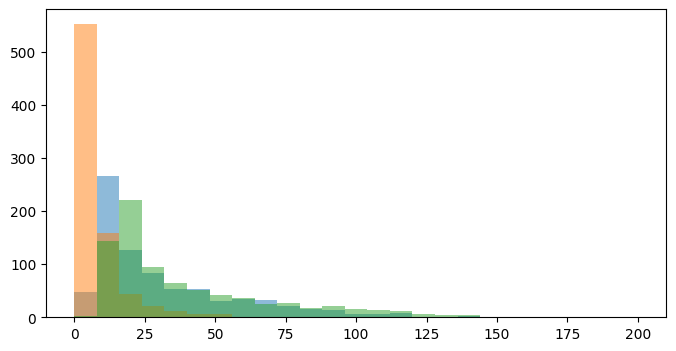

In [14]:
cnt1_list = []
cnt2_list = []
cnt3_list = []
for im_pth in img_dic.keys():
    filtered_minutiae = img_dic[im_pth]["filtered_minutiae"]
    cnt1 = 0
    cnt2 = 0
    for m in filtered_minutiae:
        if m[2]:
            cnt1 += 1
        else:
            cnt2 += 1
    cnt1_list.append(cnt1)
    cnt2_list.append(cnt2)
    cnt3_list.append(cnt1 + cnt2)
    
plt.figure(figsize=(8, 4))
plt.hist(cnt1_list, bins=25, range=(0,200), alpha=0.5)
plt.hist(cnt2_list, bins=25, range=(0,200), alpha=0.5)
plt.hist(cnt3_list, bins=25, range=(0,200), alpha=0.5)
plt.show()
plt.close()